In [7]:
import io
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from   tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB1 as CNN
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

#from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
#%pip install autokeras 
#import shutil
import PIL
import pathlib

In [9]:
#GPU 
(print(tf.__version__))
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

2.6.0


In [ ]:
MDD_training_set = "D:/Pathology_Dataset/MDD/1_train/"
MDD_val_set =      "D:/Pathology_Dataset/MDD/2_val/"

# Test db address
dataset_url_test_lab1 = "C:/Users/39351/Desktop/Databases/UnseenTestLabs/Lab1/"
dataset_url_test_lab2 = "C:/Users/39351/Desktop/Databases/UnseenTestLabs/Lab2/"
dataset_url_test_lab3 = "C:/Users/39351/Desktop/Databases/UnseenTestLabs/Lab3/"

MDD_training_dir = pathlib.Path(MDD_training_set)
MDD_val_dir = pathlib.Path(MDD_val_set)

# Set it with .jpg or .png
MDD_training_image_count = len(list(MDD_training_dir.glob('*/*.jpg')))
MDD_val_image_count = len(list(MDD_val_dir.glob('*/*.jpg')))
print("Training set volume", MDD_training_image_count)
print("Validation set volume", MDD_val_image_count )

In [12]:
'''ART = list(MDD_val_dir.glob('Artifacts/11-31114 EE/*'))
PIL.Image.open(str(ART[0]))
PIL.Image.open(str(ART[1]))'''

"ART = list(MDD_val_dir.glob('Artifacts/11-31114 EE/*'))\nPIL.Image.open(str(ART[0]))\nPIL.Image.open(str(ART[1]))"

In [9]:
batch_size = 16
img_height = 240#240-
img_width = 240#240
IMG_SIZE = img_height
AUTO = tf.data.AUTOTUNE
EPOCHS = 20#25#22#18#32

#val_split = 0.2

train_ds = tf.keras.utils.image_dataset_from_directory(
  MDD_training_dir,
  labels = 'inferred',
  label_mode ='binary',
  validation_split = False,
  follow_links = True,
  seed = 415,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 8939 files belonging to 2 classes.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  MDD_val_dir,
  labels = 'inferred',
  label_mode ='binary',
  validation_split = None,
  follow_links = True,
  seed = 415,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 3178 files belonging to 2 classes.


In [13]:
def test_data_loader(dataset_url_test):
    data_dir_test = pathlib.Path(dataset_url_test)
    print("Unseen DB address :", data_dir_test)
    test_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir_test,
        labels ='inferred',
        label_mode ='binary',
        shuffle = False,
        seed=None,
        image_size = (img_height, img_width),
        batch_size=batch_size)
    test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)
    return test_ds

In [14]:
class_names = train_ds.class_names
print(class_names)

['Artifacts', 'Normal']


Training dataset samples


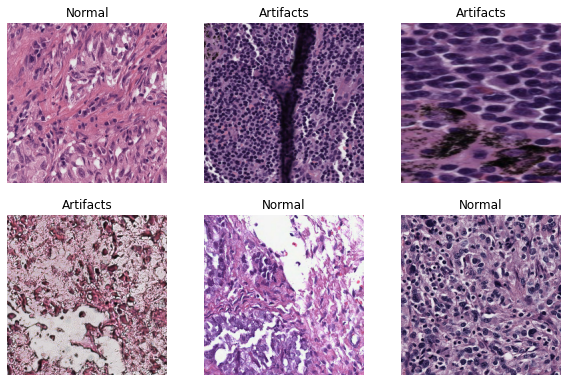

In [15]:
import matplotlib.pyplot as plt

print("Training dataset samples")
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

Validation dataset samples


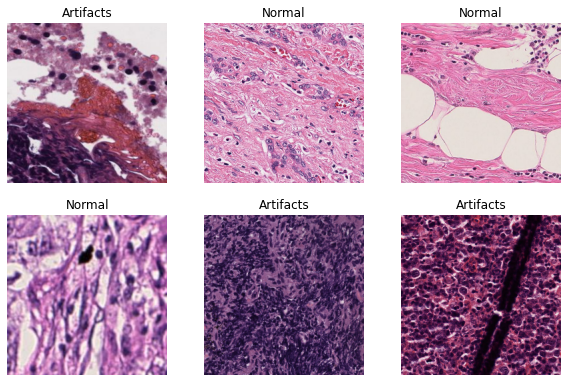

In [16]:
import matplotlib.pyplot as plt

print("Validation dataset samples")
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

In [17]:
print("Training dataset dimentions")
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

print("\nValidation dataset dimentions")
for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

Training dataset dimentions
(16, 240, 240, 3)
(16, 1)

Validation dataset dimentions
(16, 240, 240, 3)
(16, 1)


In [18]:
AUTOTUNE = tf.data.AUTOTUNE
#High performance loading
train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
#test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
'''This link is a refernce for below STN parts implementation
   (https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html)'''

'This link is a refernce for below STN parts implementation\n   (https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html)'

In [20]:
def hsv_conversion(x):
    return tf.image.rgb_to_hsv(x)

# Spatial transformer localization-network
def get_localization_network():
    localization = tf.keras.Sequential([
        layers.Lambda(hsv_conversion, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.Rescaling(1./255),
        #layers.Conv2D(8, kernel_size = 7, activation = "relu", kernel_initializer = "he_normal"),
        layers.Conv2D(8, kernel_size = 7, input_shape = (IMG_SIZE, IMG_SIZE, 3),
                         activation = "relu", kernel_initializer = "he_normal"),
        layers.MaxPool2D(strides = 2),
        layers.Conv2D(10, kernel_size = 5, activation = "relu", kernel_initializer = "he_normal"),
        #layers.SpatialDropout2D(0.5),
        layers.MaxPool2D(strides = 2),
    ])

    return localization

# Regressor for the 3 * 2 affine matrix
def get_affine_params():
    output_bias = tf.keras.initializers.Constant([1, 0, 0, 0, 1, 0])
    fc_loc = tf.keras.Sequential([
        layers.Dense(32, activation = "relu", kernel_initializer = "he_normal"),
        #layers.Dense(64, activation = "relu", kernel_initializer = "he_normal"),
        layers.Dense(3 * 2, kernel_initializer = "zeros", bias_initializer = output_bias)
    ])

    return fc_loc

In [21]:
def get_pixel_value(img, x, y):
    shape = tf.shape(x)
    batch_size = shape[0]
    height = shape[1]
    width = shape[2]

    batch_idx = tf.range(0, batch_size)
    batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1))
    b = tf.tile(batch_idx, (1, height, width))

    indices = tf.stack([b, y, x], 3)

    return tf.gather_nd(img, indices)

In [22]:
def affine_grid_generator(height, width, theta):
    num_batch = tf.shape(theta)[0]

    # create normalized 2D grid
    x = tf.linspace(-1.0, 1.0, width)
    y = tf.linspace(-1.0, 1.0, height)
    x_t, y_t = tf.meshgrid(x, y)

    # flatten
    x_t_flat = tf.reshape(x_t, [-1])
    y_t_flat = tf.reshape(y_t, [-1])

    # reshape to [x_t, y_t , 1] - (homogeneous form)
    ones = tf.ones_like(x_t_flat)
    sampling_grid = tf.stack([x_t_flat, y_t_flat, ones])

    # repeat grid num_batch times
    sampling_grid = tf.expand_dims(sampling_grid, axis=0)
    sampling_grid = tf.tile(sampling_grid, tf.stack([num_batch, 1, 1]))

    # cast to float32 (required for matmul)
    theta = tf.cast(theta, 'float32')
    sampling_grid = tf.cast(sampling_grid, 'float32')

    # transform the sampling grid - batch multiply
    batch_grids = tf.matmul(theta, sampling_grid)
    # batch grid has shape (num_batch, 2, H*W)

    # reshape to (num_batch, H, W, 2)
    batch_grids = tf.reshape(batch_grids, [num_batch, 2, height, width])

    return batch_grids

In [23]:
def bilinear_sampler(img, x, y):
    H = tf.shape(img)[1]
    W = tf.shape(img)[2]
    max_y = tf.cast(H - 1, 'int32')
    max_x = tf.cast(W - 1, 'int32')
    zero = tf.zeros([], dtype='int32')

    # rescale x and y to [0, W-1/H-1]
    x = tf.cast(x, 'float32')
    y = tf.cast(y, 'float32')
    x = 0.5 * ((x + 1.0) * tf.cast(max_x-1, 'float32'))
    y = 0.5 * ((y + 1.0) * tf.cast(max_y-1, 'float32'))

    # grab 4 nearest corner points for each (x_i, y_i)
    x0 = tf.cast(tf.floor(x), 'int32')
    x1 = x0 + 1
    y0 = tf.cast(tf.floor(y), 'int32')
    y1 = y0 + 1

    # clip to range [0, H-1/W-1] to not violate img boundaries
    x0 = tf.clip_by_value(x0, zero, max_x)
    x1 = tf.clip_by_value(x1, zero, max_x)
    y0 = tf.clip_by_value(y0, zero, max_y)
    y1 = tf.clip_by_value(y1, zero, max_y)

    # get pixel value at corner coords
    Ia = get_pixel_value(img, x0, y0)
    Ib = get_pixel_value(img, x0, y1)
    Ic = get_pixel_value(img, x1, y0)
    Id = get_pixel_value(img, x1, y1)

    # recast as float for delta calculation
    x0 = tf.cast(x0, 'float32')
    x1 = tf.cast(x1, 'float32')
    y0 = tf.cast(y0, 'float32')
    y1 = tf.cast(y1, 'float32')

    # calculate deltas
    wa = (x1-x) * (y1-y)
    wb = (x1-x) * (y-y0)
    wc = (x-x0) * (y1-y)
    wd = (x-x0) * (y-y0)

    # add dimension for addition
    wa = tf.expand_dims(wa, axis=3)
    wb = tf.expand_dims(wb, axis=3)
    wc = tf.expand_dims(wc, axis=3)
    wd = tf.expand_dims(wd, axis=3)

    # compute output
    out = tf.add_n([wa*Ia, wb*Ib, wc*Ic, wd*Id])

    return out

In [24]:
'''Spatial transformer network forward function'''
def stn(x):
    localization = get_localization_network()
    fc_loc = get_affine_params()
    
    xs = localization(x)
    #EfficientNet: B0(52), B1(56), B2(?), B3(142), B5(220)
    xs = tf.reshape(xs, (-1, 10 * 56 * 56))
    theta = fc_loc(xs)
    theta = tf.reshape(theta, (-1, 2, 3))
    
    grid = affine_grid_generator(IMG_SIZE, IMG_SIZE, theta)
    #grid = affine_grid_generator(300, 300, theta)
    x_s = grid[:, 0, :, :]
    y_s = grid[:, 1, :, :]
    x = bilinear_sampler(x, x_s, y_s)

    return x
#model.add(Lambda(hsv_conversion, input_shape=(160, 320, 3)))

In [25]:
'''Creating an intefrated neural network by adding a STN as input an CNN'''
def get_training_model(use_stn = True, improved_effnet = True):
    #inputs = layers.Input((224, 224, 3))
    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    if use_stn:
        x = stn(inputs)
    else:
        x = inputs

    #model = tf.keras.applications.efficientnet_v2.EfficientNetV2S(include_top = False, input_tensor = x, weights = None)
    model = CNN (include_top = False, input_tensor = x, weights = None)

    if improved_effnet == False:
        #model = CNN (include_top = False, input_tensor = x, weights = None)
        x = layers.GlobalAveragePooling2D(name = "avg_pool")(model.output)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('swish')(x)
        #x = layers.Dropout(0.5, name="top_dropout")(x)

    elif improved_effnet == True:
        #model = CNN (include_top = False, input_tensor = x, weights = None, drop_connect_rate=0.4)
        #model = CNN (include_top = False, input_tensor = x, weights = None)
        # l2(0.0001)
        #it is very important : Conv2D (10, (5,5))
        #x = layers.GlobalMaxPooling2D(name = "max_pool")(model.output)
        #x = layers.Dropout(0.1)(x)
        x = layers.Conv2D(10, (5, 5), dilation_rate = (2, 2), padding = 'same')(model.output)
        #x = layers.Conv2D(10, (5, 5), padding = 'same')(model.output)
        #x = layers.SpatialDropout2D(0.5)(x)
        #x = layers.GlobalAveragePooling2D(name = "avg_pool")(model.output)
        x = layers.GlobalAveragePooling2D(name = "avg_pool")(x)
        #x = layers.GlobalMaxPooling2D(name = "max_pool")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('swish')(x)
        #x = layers.Dropout(0.1, name = "top_dropout")(x)

        x = layers.Dense(256, activation = "swish", activity_regularizer = l2(0.0001), name = "FC_256")(x)
        #x = layers.Dense(256, activation = "swish", name = "FC_256")(x)
        #x = BatchNormalization()(x)
        #x = layers.Dropout(0.50)(x) # It reduce perf
    
        x = layers.Dense(64, activation = "swish", name = "features_vector")(x)
        #x = BatchNormalization()(x)
        #x = layers.Dropout(0.2, name = "top_dropout")(x)

    outputs = layers.Dense(1, activation = "sigmoid", name = "pred")(x)
    
    return tf.keras.Model(inputs, outputs)

In [26]:
'''Networks' Parameters claculations'''
num_params_w_tcnn = get_training_model().count_params()
num_params_wo_tcnn = get_training_model(False).count_params()
print(f"Parameters of the TCNN with STN's layers: {num_params_w_tcnn / 1e6} M")
print(f"Parameters of the TCNN without STN's layers: {num_params_wo_tcnn / 1e6} M")

Parameters of the TCNN with STN's layers: 7.921562 M
Parameters of the TCNN without STN's layers: 6.914618 M


In [27]:
# Showing effect of the STN on an image even before the training
'''Here's the original image.''' 
'''plt.imshow(x_train[0].squeeze(), cmap = "binary")
plt.show()

Here is the transformed image'''
'''transformed_x = stn(np.expand_dims(x_train[0], 0))
plt.imshow(transformed_x.numpy().squeeze(), cmap="binary")
plt.show()'''

'transformed_x = stn(np.expand_dims(x_train[0], 0))\nplt.imshow(transformed_x.numpy().squeeze(), cmap="binary")\nplt.show()'

In [28]:
#We can write a custom callback to log how the transformations learned by STN evolve over time

tcnn_model = get_training_model(True, True)
#stn_model.layers[109].dilation_rate = (2, 2)
#stn_model.layers[109].strides = (1, 1)

#stn_model.layers[134].dilation_rate = (2, 2)
#stn_model.layers[134].strides = (1, 1)

tcnn_mini_model = tf.keras.Model(tcnn_model.input, tcnn_model.layers[100].output)
file_writer_cm = tf.summary.create_file_writer("logs/stn_progress")

# Courtesy: https://www.tensorflow.org/tensorboard/image_summaries
def plot_to_image(figure):
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    
    # Closing the figure prevents it from being displayed directly inside the notebook.
    plt.close(figure)
    buf.seek(0)
    
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

def log_progression(epoch, logs):
    sampled_transformed = tcnn_mini_model(train_ds[:25])
    
    figure = plt.figure(figsize = (10, 10))
    for n in range(25):
        plt.subplot(5, 5, n+1)
        plt.imshow(sampled_transformed[n].numpy().squeeze(), cmap = "binary")
        plt.axis("off")

    progress_image = plot_to_image(figure)
    with file_writer_cm.as_default():
        tf.summary.image("Progression", progress_image, step = epoch)

# Define the per-epoch callback.
progress_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end = log_progression)

In [29]:
'''Plot accuacies during training'''
def plot_hist(hist, EPOCHS):
    rng = list(range(1, EPOCHS+1))
    #prc = list(range(0,100))
    plt.plot(rng, hist.history["accuracy"])
    plt.plot(rng, hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    #specify axis tick step sizes
    plt.xticks(np.arange(min(rng), max(rng), 2))
    #plt.yticks(np.arange(min(prc), max(prc), 10))
    #plt.xlim([1, EPOCHS])
    #plt.ylim([50, 50])
    plt.legend(["train", "validation"], loc="lower right")
    plt.show()
    #plt.savefig(str(fold_no) + 'stn_accuracies.png')

In [30]:
def Sen_Spe_F1(tp, tn, fp, fn):
    accuracy = (tp+ tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    F1_score = (2 * tp) / ((2 * tp) + fp + fn)
    return accuracy, sensitivity, specificity, F1_score

In [31]:
def scheduler(epoch, lr):
   if epoch < 3:
     return lr
   else:
     return lr * tf.math.exp(-0.1)

In [32]:
'''In this cell, the network is prepared to start traning'''
# Define callbacks options
#early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 10, mode = 'max')
#early_stopping = EarlyStopping(monitor='val_loss', mode='min', baseline=0.0040)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1, patience = 7, verbose = 1, min_delta = 1e-4, mode = 'max')
best_stn_model = ModelCheckpoint('best_model/best_stn_model.hdf5', save_best_only = True, monitor = 'val_accuracy', mode = 'max')
lr_rate_sched = tf.keras.callbacks.LearningRateScheduler(scheduler)

TN = keras.metrics.TrueNegatives()
TP = keras.metrics.TruePositives()
FN = keras.metrics.FalseNegatives()
FP = keras.metrics.FalsePositives()
SEN = keras.metrics.Recall()
AUC = keras.metrics.AUC()
SPE = tf.keras.metrics.SpecificityAtSensitivity(0.5)
SENS= tf.keras.metrics.SensitivityAtSpecificity(0.5)

opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
#opt = tf.keras.optimizers.Ftrl(learning_rate = 0.001)
#stn_model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ['accuracy', TN, TP, FN, FP, SEN, AUC, SPE, SENS])
#ls = tf.keras.losses.BinaryCrossentropy(from_logits=True)
tcnn_model.compile(loss = "binary_crossentropy", optimizer =  opt , metrics = ['accuracy', TN, TP, FN, FP, SEN, AUC, SPE, SENS])
tcnn_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 56, 56, 10)   3194        input_3[0][0]                    
__________________________________________________________________________________________________
tf.reshape_7 (TFOpLambda)       (None, 31360)        0           sequential_2[0][0]               
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 6)            1003750     tf.reshape_7[0][0]               
____________________________________________________________________________________________

In [33]:
print("TCNN training has being strated")
with tf.device('/device:GPU:0'):
   print("tf.keras code in this scope will run on GPU")
   tcnn_hist = tcnn_model.fit(train_ds, 
              validation_data = val_ds, 
              epochs = EPOCHS,
              verbose = 2,
              callbacks = [lr_rate_sched, best_stn_model])
print("TCNN Model_Average accuracy on the best model: ", max(tcnn_hist.history["val_accuracy"]))

TCNN training has being strated
tf.keras code in this scope will run on GPU
Epoch 1/20
559/559 - 184s - loss: 0.3668 - accuracy: 0.8399 - true_negatives: 4377.0000 - true_positives: 3131.0000 - false_negatives: 690.0000 - false_positives: 741.0000 - recall: 0.8194 - auc: 0.9147 - specificity_at_sensitivity: 0.9609 - sensitivity_at_specificity: 0.9796 - val_loss: 0.2351 - val_accuracy: 0.9235 - val_true_negatives: 1199.0000 - val_true_positives: 1736.0000 - val_false_negatives: 219.0000 - val_false_positives: 24.0000 - val_recall: 0.8880 - val_auc: 0.9821 - val_specificity_at_sensitivity: 0.9992 - val_sensitivity_at_specificity: 0.9841


c:\Users\39351\anaconda3\envs\TFgpuKeras\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
559/559 - 151s - loss: 0.2395 - accuracy: 0.9141 - true_negatives: 4708.0000 - true_positives: 3463.0000 - false_negatives: 358.0000 - false_positives: 410.0000 - recall: 0.9063 - auc: 0.9598 - specificity_at_sensitivity: 0.9773 - sensitivity_at_specificity: 0.9942 - val_loss: 0.1548 - val_accuracy: 0.9572 - val_true_negatives: 1119.0000 - val_true_positives: 1923.0000 - val_false_negatives: 32.0000 - val_false_positives: 104.0000 - val_recall: 0.9836 - val_auc: 0.9842 - val_specificity_at_sensitivity: 0.9902 - val_sensitivity_at_specificity: 0.9995
Epoch 3/20
559/559 - 146s - loss: 0.2005 - accuracy: 0.9311 - true_negatives: 4767.0000 - true_positives: 3556.0000 - false_negatives: 265.0000 - false_positives: 351.0000 - recall: 0.9306 - auc: 0.9710 - specificity_at_sensitivity: 0.9826 - sensitivity_at_specificity: 0.9971 - val_loss: 0.1219 - val_accuracy: 0.9575 - val_true_negatives: 1171.0000 - val_true_positives: 1872.0000 - val_false_negatives: 83.0000 - val_false_positiv

In [34]:
tcnn_model.save('best_model/TCNN_model.hdf5')
#loaded_stn_model = keras.models.load_model('best_model/best_stn_model.hdf5')

In [199]:
# Metrics
def print_results(type ,loss, acc, tn, tp, fn, fp, senv, auc, spec, sensAt):
    #print(type + " Acc: {:.2f}%".format(stn_acc * 100))
    #print(type + "Sens (Recall): {:.2f}%".format(stn_senv * 100))
    #print(type + " SensAtSpec: {:.2f}%".format(stn_sensAt * 100))
    #print(type + "Spec: {:.2f}%".format(stn_spec * 100))

    accuracy, sensitivity, specificity, F1_score = Sen_Spe_F1(tp, tn, fp, fn)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    print("Sensitivity: {:.2f}%".format(sensitivity * 100))
    print("Specificity: {:.2f}%".format(specificity * 100))
    print("F1-Score: {:.2f}%".format(F1_score * 100))
    print("AUC: {:.2f}%".format(auc * 100))
    return accuracy, sensitivity, specificity, F1_score, auc

In [37]:
train_labels = np.concatenate([y for x, y in train_ds], axis=0)
val_labels = np.concatenate([y for x, y in val_ds], axis=0) 
#test_labels = np.concatenate([y for x, y in test_ds], axis=0) 
#print(val_labels)

'''for image, target in val_ds:
  y = tcnn_model(image, training=False)  # Or y = model.predict(image)
  # then compare y with target
print(y)'''

'''test_ds_lab = test_data_loader(dataset_url_test_lab2)
test_labels = np.concatenate([y for x, y in test_ds_lab], axis=0)
prob_score_tcnn = []
prob_score_tcnn = stn_model.predict(test_ds_lab)'''

'test_ds_lab = test_data_loader(dataset_url_test_lab2)\ntest_labels = np.concatenate([y for x, y in test_ds_lab], axis=0)\nprob_score_tcnn = []\nprob_score_tcnn = stn_model.predict(test_ds_lab)'

In [38]:
prob_score_tcnn = []
prob_score_tcnn = tcnn_model.predict(val_ds)
#prob_score_tcnn = prob_score_tcnn[1, :]
#print((prob_score_tcnn))

In [40]:
# https://neptune.ai/blog/brier-score-and-model-calibration
from sklearn.metrics import brier_score_loss, roc_auc_score

print("Brier score loss: ", brier_score_loss(val_labels, prob_score_tcnn, pos_label = 1))
print("ROC-AUC score: ", roc_auc_score(val_labels, prob_score_tcnn))

Brier score loss:  0.02724938707468243
ROC-AUC score:  0.9909078551965419


In [41]:
# Compute a confidence interval from sample data: https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
import numpy as np, scipy.stats as st
print(st.t.interval(0.95, len(prob_score_tcnn)-1, loc=np.mean(prob_score_tcnn), scale=st.sem(prob_score_tcnn)))

(array([0.59350129]), array([0.62698595]))


In [42]:
import numpy as np
import scipy.stats

def mean_confidence_interval(probability_score, confidence = 0.95):
    a = 1.0 * np.array(probability_score)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [105]:
intrv_TCNN, intrv2_TCNN, intrv3_TCNN = mean_confidence_interval(prob_score_tcnn, confidence = 0.95)
print(intrv_TCNN, intrv2_TCNN, intrv3_TCNN)

0.6102436 [0.59350127] [0.62698597]


In [200]:
##############################      Train db        ###########################
type = "Training set - TCNN evaluation"
tcnn_loss, tcnn_acc,tcnn_tn, tcnn_tp, tcnn_fn, tcnn_fp, tcnn_senv, tcnn_auc, tcnn_spec, tcnn_sensAt = tcnn_model.evaluate(train_ds)
tcnn_train_accuracy, tcnn_train_sensitivity, tcnn_train_specificity, tcnn_train_F1_score, tcnn_train_auc = print_results(type ,tcnn_loss, tcnn_acc, tcnn_tn, tcnn_tp, tcnn_fn, tcnn_fp, tcnn_senv, tcnn_auc, tcnn_spec, tcnn_sensAt)

559/559 [==============================] - 67s 119ms/step - loss: 0.0276 - accuracy: 0.9925 - true_negatives: 5088.0000 - true_positives: 3784.0000 - false_negatives: 37.0000 - false_positives: 30.0000 - recall: 0.9903 - auc: 0.9987 - specificity_at_sensitivity: 0.9982 - sensitivity_at_specificity: 0.9997
Accuracy: 99.25%
Sensitivity: 99.03%
Specificity: 99.41%
F1-Score: 99.12%
AUC: 99.87%


In [202]:
##############################      Validation ds   ###########################
type = "Validation set - TCNN evaluation"
tcnn_loss, tcnn_acc, tcnn_tn, tcnn_tp, tcnn_fn, tcnn_fp, tcnn_senv, tcnn_auc, tcnn_spec, tcnn_sensAt = tcnn_model.evaluate(val_ds)
print(tcnn_acc, tcnn_senv, tcnn_spec,'?', tcnn_auc)
tcnn_val_accuracy, tcnn_val_sensitivity, tcnn_val_specificity, tcnn_val_F1_score, tcnn_val_auc = print_results(type ,tcnn_loss,tcnn_acc, tcnn_tn, tcnn_tp, tcnn_fn, tcnn_fp, tcnn_senv, tcnn_auc, tcnn_spec, tcnn_sensAt)

199/199 [==============================] - 16s 80ms/step - loss: 0.1595 - accuracy: 0.9685 - true_negatives: 1180.0000 - true_positives: 1898.0000 - false_negatives: 57.0000 - false_positives: 43.0000 - recall: 0.9708 - auc: 0.9852 - specificity_at_sensitivity: 0.9869 - sensitivity_at_specificity: 0.9877
0.9685336947441101 0.9708439707756042 0.9869174361228943 ? 0.985190749168396
Accuracy: 96.85%
Sensitivity: 97.08%
Specificity: 96.48%
F1-Score: 97.43%
AUC: 98.52%


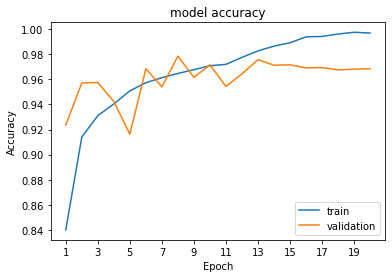

In [48]:
plot_hist(tcnn_hist, EPOCHS)

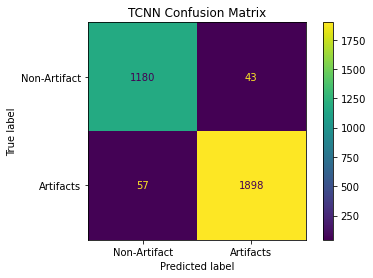

In [196]:
import matplotlib.pyplot as plt_TCNN
from sklearn import metrics

y_pred_class_tcnn = np.round(prob_score_tcnn)
confusion_matrix_tcnn = metrics.confusion_matrix(val_labels, y_pred_class_tcnn) 

cm_display_tcnn = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_tcnn, display_labels = ["Non-Artifact", "Artifacts"])
cm_display_tcnn.plot()
cm_display_tcnn.ax_.set_title("TCNN Confusion Matrix")
plt_TCNN.show() 

In [ ]:
#############################   Test DB   ################################
#loaded_stn_model = keras.models.load_model('best_model/best_stn_model.hdf5')
test_ds_lab1 = test_data_loader(dataset_url_test_lab1)
tcnn_loss, tcnn_acc, tcnn_tn, tcnn_tp, tcnn_fn, tcnn_fp, tcnn_senv, tcnn_auc, tcnn_spec, tcnn_sensAt = tcnn_model.evaluate(test_ds_lab1)
type = "Test set (Lab1) - TCNN evaluation"
print_results(type ,tcnn_loss, tcnn_acc, tcnn_tn, tcnn_tp, tcnn_fn, tcnn_fp, tcnn_senv, tcnn_auc, tcnn_spec, tcnn_sensAt)

In [ ]:
test_ds_lab2 = test_data_loader(dataset_url_test_lab2)
tcnn_loss, tcnn_acc, tcnn_tn, tcnn_tp, tcnn_fn, tcnn_fp, tcnn_senv, tcnn_auc, tcnn_spec, tcnn_sensAt = tcnn_model.evaluate(test_ds_lab2)
type = "Test set (Lab2) - TCNN evaluation"
print_results(type ,tcnn_loss, tcnn_acc, tcnn_tn, tcnn_tp, tcnn_fn, tcnn_fp, tcnn_senv, tcnn_auc, tcnn_spec, tcnn_sensAt)

In [ ]:
test_ds_lab3 = test_data_loader(dataset_url_test_lab3)
tcnn_loss, tcnn_acc, tcnn_tn, tcnn_tp, tcnn_fn, tcnn_fp, tcnn_senv, tcnn_auc, tcnn_spec, tcnn_sensAt = tcnn_model.evaluate(test_ds_lab3)
type = "Test set (Lab3) - TCNN evaluation"
print_results(type ,tcnn_loss, tcnn_acc, tcnn_tn, tcnn_tp, tcnn_fn, tcnn_fp, tcnn_senv, tcnn_auc, tcnn_spec, tcnn_sensAt)

In [ ]:
print("The training of EfficientNet CNN has being strated")
#early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 10, mode = 'max')
#early_stopping = EarlyStopping(monitor='val_loss', mode='min', baseline=0.0040)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1, patience = 7, verbose = 1, min_delta = 1e-4, mode = 'max')
best_ordinary_model = ModelCheckpoint('best_model/best_ordinary_model.hdf5', save_best_only = True, monitor = 'val_accuracy', mode = 'max')

eff_net = get_training_model(use_stn = False, improved_effnet = False)

opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
#improved_net.compile(loss = "binary_crossentropy", optimizer = 'adam', metrics = ['accuracy', TN, TP, FN, FP, SEN, AUC, SPE, SENS])
eff_net.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ['accuracy', TN, TP, FN, FP, SEN, AUC, SPE, SENS])
eff_net.summary()

#eph = round(0.75*EPOCHS)-1# - round(EPOCHS/3)
#Using Eph 15 for Eff and 25 for TCNN, all work.
with tf.device('/device:GPU:0'):
    print("tf.keras code in this scope will run on GPU")
    imp_hist = eff_net.fit(train_ds,
              validation_data = val_ds, 
              epochs = EPOCHS,
              verbose = 2,
              callbacks = [reduce_lr, best_ordinary_model])

eff_net.save('best_model/EffNet_model.hdf5')
#loaded_eff_net = keras.models.load_model('best_model/EffNet_model.hdf5')
#loaded_ordinary_model = keras.models.load_model('best_model/best_ordinary_model.hdf5')

In [55]:
prob_score_eff_net = []
prob_score_eff_net= eff_net.predict(val_ds)
#prob_score_eff_net = prob_score_eff_net[1, :]
#print((prob_score_eff_net))

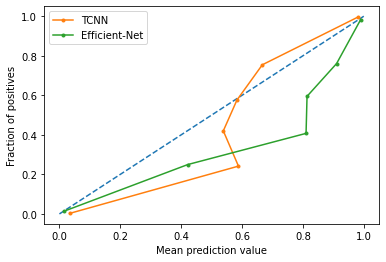

In [100]:
# https://neptune.ai/blog/brier-score-and-model-calibration
from sklearn.calibration import calibration_curve
n_bins = 6
x_p_tcnn, y_p_tcnn = calibration_curve(val_labels, prob_score_tcnn, n_bins = n_bins, normalize = True)
x_p_eff, y_p_eff = calibration_curve(val_labels, prob_score_eff_net, n_bins = n_bins, normalize = True)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(x_p_tcnn, y_p_tcnn, marker='.',  label = 'TCNN')
plt.plot(x_p_eff, y_p_eff, marker='.',  label = 'Efficient-Net')
plt.xlabel('Mean prediction value')
plt.ylabel('Fraction of positives')
plt.legend()
plt.show()

In [ ]:
print("Efficient Net", (x_p_eff), (y_p_eff))
print("TCNN         ", (x_p_tcnn), (y_p_tcnn))

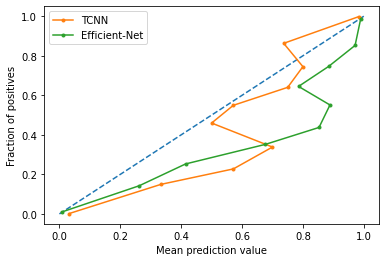

In [58]:
# https://neptune.ai/blog/brier-score-and-model-calibration
from sklearn.calibration import calibration_curve
n_bins = 10
x_p_tcnn, y_p_tcnn = calibration_curve(val_labels, prob_score_tcnn, n_bins = n_bins, normalize = True)
x_p_eff, y_p_eff = calibration_curve(val_labels, prob_score_eff_net, n_bins = n_bins, normalize = True)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(x_p_tcnn, y_p_tcnn, marker='.',  label = 'TCNN')
plt.plot(x_p_eff, y_p_eff, marker='.',  label = 'Efficient-Net')
plt.xlabel('Mean prediction value')
plt.ylabel('Fraction of positives')
plt.legend()
plt.show()

In [389]:
print("Efficient Net", (x_p_eff), (y_p_eff))
print("TCNN         ", (x_p_tcnn), (y_p_tcnn))

Efficient Net [0.01639344 0.421875   0.81034483 0.81355932 0.91071429 0.98933782] [0.01440724 0.24980623 0.40745534 0.59484576 0.7607084  0.98182739]
TCNN          [0.03314002 0.58823529 0.53846154 0.58333333 0.66666667 0.98226395] [0.00242139 0.24180029 0.42011229 0.57622393 0.75444037 0.99695522]


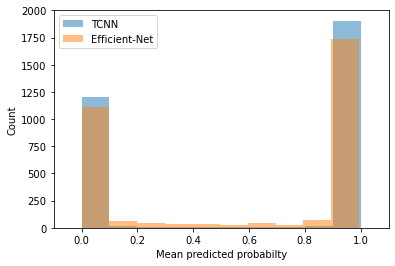

In [173]:
# plot histogram with 255 bins
b1, bins1, patches1 = plt.hist(prob_score_tcnn, 10, alpha=0.5, label="TCNN")
b2, bins2, patches2 = plt.hist(prob_score_eff_net, 10, alpha=0.5, label="Efficient-Net")

plt.xlabel("Mean predicted probabilty", size = 10)
plt.ylabel("Count", size = 10)
plt.legend(loc='upper left')
plt.xlim([-0.1,1.1])
plt.ylim([0,2000])
plt.plot(c = 'red')
plt.show()

In [104]:
# https://neptune.ai/blog/brier-score-and-model-calibration
from sklearn.metrics import brier_score_loss, roc_auc_score

print("Brier score loss: ", brier_score_loss(val_labels, prob_score_eff_net, pos_label = 1))
print("ROC-AUC score: ", roc_auc_score(val_labels, prob_score_eff_net))

Brier score loss:  0.028283438999070175
ROC-AUC score:  0.9915624026282275


In [62]:
# Compute a confidence interval from sample data: https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
import numpy as np, scipy.stats as st

print(st.t.interval(0.95, len(prob_score_eff_net)-1, loc=np.mean(prob_score_eff_net), scale=st.sem(prob_score_eff_net)))

(array([0.57307203]), array([0.60484342]))


In [106]:
intrv_eff_net, intrv2_eff_net, intrv3_eff_net = mean_confidence_interval(prob_score_eff_net, confidence = 0.95)
print(intrv_eff_net, intrv2_eff_net, intrv3_eff_net)

0.5889577 [0.573072] [0.60484344]


In [65]:
import scipy.stats

def mean_confidence_interval(probability_score, confidence = 0.95):
    a = 1.0 * np.array(probability_score)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

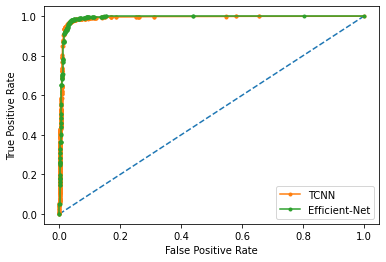

In [67]:
# calculate roc curves
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

ns_fpr, ns_tpr, _ = roc_curve(val_labels, prob_score_tcnn)
lr_fpr, lr_tpr, _ = roc_curve(val_labels, prob_score_eff_net)

# plot the roc curve for the model
pyplot.plot([0, 1], [0, 1], linestyle = '--')
pyplot.plot(ns_fpr, ns_tpr, marker = '.', label = 'TCNN')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Efficient-Net')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [68]:
print("EfficientNet: Average accuracy on the best model: ", max(imp_hist.history["val_accuracy"]))

EfficientNet: Average accuracy on the best model:  0.9801762104034424


In [226]:
type = "Training set - EfficientNet evaluation"
imp_loss, imp_acc, imp_tn, imp_tp, imp_fn, imp_fp, imp_senv, imp_auc, imp_spec, imp_sensAt = eff_net.evaluate(train_ds)
eff_net_train_accuracy, eff_net_train_sensitivity, eff_net_train_specificity, eff_net_train_F1_score, eff_net_train_auc = print_results(type ,imp_loss, imp_acc, imp_tn, imp_tp, imp_fn, imp_fp, imp_senv, imp_auc, imp_spec, imp_sensAt)

559/559 [==============================] - 26s 46ms/step - loss: 0.1068 - accuracy: 0.9622 - true_negatives: 4921.0000 - true_positives: 3680.0000 - false_negatives: 141.0000 - false_positives: 197.0000 - recall: 0.9631 - auc: 0.9925 - specificity_at_sensitivity: 0.9979 - sensitivity_at_specificity: 1.0000
Accuracy: 96.22%
Sensitivity: 96.31%
Specificity: 96.15%
F1-Score: 95.61%
AUC: 99.25%


In [227]:
type = "Validation set - EfficientNet evaluation"
imp_loss, imp_acc, imp_tn, imp_tp, imp_fn, imp_fp, imp_senv, imp_auc, imp_spec, imp_sensAt = eff_net.evaluate(val_ds)
eff_net_val_accuracy, eff_net_val_sensitivity, eff_net_val_specificity, eff_net_val_F1_score, eff_net_val_auc = print_results(type ,imp_loss, imp_acc, imp_tn, imp_tp, imp_fn, imp_fp, imp_senv, imp_auc, imp_spec, imp_sensAt)

199/199 [==============================] - 16s 80ms/step - loss: 0.1033 - accuracy: 0.9594 - true_negatives: 1188.0000 - true_positives: 1861.0000 - false_negatives: 94.0000 - false_positives: 35.0000 - recall: 0.9519 - auc: 0.9912 - specificity_at_sensitivity: 0.9943 - sensitivity_at_specificity: 0.9995
Accuracy: 95.94%
Sensitivity: 95.19%
Specificity: 97.14%
F1-Score: 96.65%
AUC: 99.12%


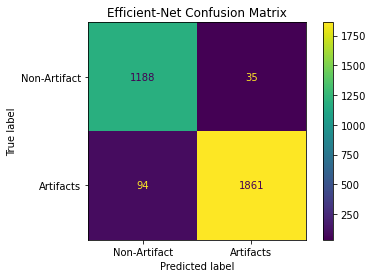

In [194]:
import matplotlib.pyplot as plt_eff_net
from sklearn import metrics

y_pred_class_eff_net = np.round(prob_score_eff_net)
confusion_matrix_eff_net = metrics.confusion_matrix(val_labels, y_pred_class_eff_net) 

cm_display_eff_net = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_eff_net , display_labels = ["Artifacts", "Non-Artifact"])
cm_display_eff_net.plot()
cm_display_eff_net.ax_.set_title("Efficient-Net Confusion Matrix")
plt_eff_net.show() 

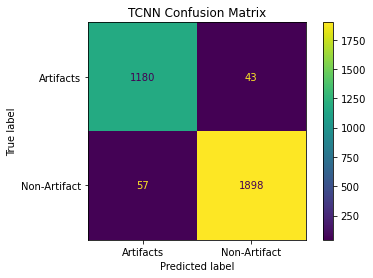

In [195]:
cm_display_tcnn.plot()
cm_display_tcnn.ax_.set_title("TCNN Confusion Matrix")
plt_TCNN.show() 

In [ ]:
test_ds_lab1 = test_data_loader(dataset_url_test_lab1)
imp_loss, imp_acc, imp_tn, imp_tp, imp_fn, imp_fp, imp_senv, imp_auc, imp_spec, imp_sensAt = eff_net.evaluate(test_ds_lab1)
type = "Test set (Lab1) - EfficientNet evaluation"
print_results(type ,imp_loss, imp_acc, imp_tn, imp_tp, imp_fn, imp_fp, imp_senv, imp_auc, imp_spec, imp_sensAt)

In [ ]:
test_ds_lab2 = test_data_loader(dataset_url_test_lab2)
imp_loss, imp_acc, imp_tn, imp_tp, imp_fn, imp_fp, imp_senv, imp_auc, imp_spec, imp_sensAt = eff_net.evaluate(test_ds_lab2)
type = "Test set (Lab2) - EfficientNet evaluation"
print_results(type ,imp_loss, imp_acc, imp_tn, imp_tp, imp_fn, imp_fp, imp_senv, imp_auc, imp_spec, imp_sensAt)

In [ ]:
test_ds_lab3 = test_data_loader(dataset_url_test_lab3)
imp_loss, imp_acc, imp_tn, imp_tp, imp_fn, imp_fp, imp_senv, imp_auc, imp_spec, imp_sensAt = eff_net.evaluate(test_ds_lab3)
type = "Test set (Lab3) - EfficientNet evaluation"
print_results(type ,imp_loss, imp_acc, imp_tn, imp_tp, imp_fn, imp_fp, imp_senv, imp_auc, imp_spec, imp_sensAt)

In [81]:
def pred(model_name, samples_to_predict):
    predictions = model_name.predict(samples_to_predict)
    #print(predictions)
    # Generate arg maxes for predictions
    #classes = np.argmax(predictions, axis = 1)
    #print(classes)
    return predictions

In [83]:
#print(prediction_result_for_positive)
'''np.savetxt('predresultvaules.csv', prediction_result_for_positive)'''

"np.savetxt('predresultvaules.csv', prediction_result_for_positive)"

In [85]:
print(len(tcnn_model.layers))
print(len(eff_net.layers))

451
343


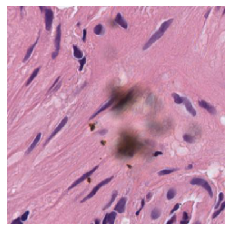

In [51]:
#calculating features_map
# https://www.kaggle.com/code/arpitjain007/guide-to-visualize-filters-and-feature-maps-in-cnn
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from numpy import expand_dims
img_add = "C:/Users/39351/Desktop/MDD_divided_Fold1/2_val/Artifacts/GastricMuc/GastricMuc_null8.jpg"
#image = load_img(img_add)
image = load_img(img_add , target_size=(240,240))
#image = load_img("C:/Users/39351/Desktop/MDD_divided_Fold1/2_val/Artifacts/TCGA-FA-A6HO-01Z-00-DX1.9E6256E7-5C4A-4D57-9810-8F52D3826BC7/TCGA-FA-A6HO-01Z-00-DX1.9E6256E7-5C4A-4D57-9810-8F52D3826BC7_null58.jpg")
pyplot.axis('off')
pyplot.imshow(image)

# convert the image to an array
image = img_to_array(image)
# expand dimensions so that it represents a single 'sample'
image = expand_dims(image, axis=0)

In [16]:
from tensorflow.keras.models import Model
activation_tcnn_model = Model(inputs = tcnn_model.inputs, outputs = tcnn_model.layers[335].output) #203, 174
activation_eff_net = Model(inputs = eff_net.inputs, outputs = eff_net.layers[230].output) #98

In [218]:
#calculating features_map
#https://www.kaggle.com/code/arpitjain007/guide-to-visualize-filters-and-feature-maps-in-cnn
features_tcnn = activation_tcnn_model.predict(image)

In [ ]:
fig = pyplot.figure(figsize=(20,20))
for i in range(1,features_tcnn.shape[3]+1):

    pyplot.subplot(8,8,i)
    pyplot.axis('off')
    pyplot.imshow(features_tcnn[0,:,:,i-1])# , cmap='gray')
    
pyplot.show()

In [206]:
#https://www.kaggle.com/code/arpitjain007/guide-to-visualize-filters-and-feature-maps-in-cnn
features_eff_net = activation_eff_net.predict(image)

In [ ]:
fig = pyplot.figure(figsize=(20,20))
for i in range(1,features_eff_net.shape[3]+1):

    pyplot.subplot(8,8,i)
    pyplot.axis('off')
    pyplot.imshow(features_eff_net[0,:,:,i-1])# , cmap='gray')
    
pyplot.show()

In [52]:

outputs = [tcnn_model.layers[i].output for i in blocks]

tcnn_model_activation= Model( inputs = tcnn_model.inputs, outputs = outputs)

In [56]:
tcnn_model_first_meaningful_layer = Model(inputs = tcnn_model.inputs, outputs = tcnn_model.layers[108].output)
tcnn_features = tcnn_model_first_meaningful_layer.predict(image)
print("finish 1")
feature_map = tcnn_model_activation.predict(image)
print("finish 2")

finish 1
finish 2


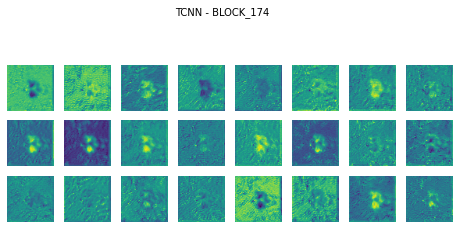

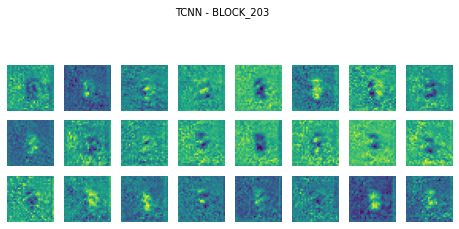

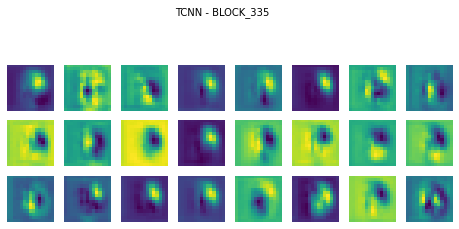

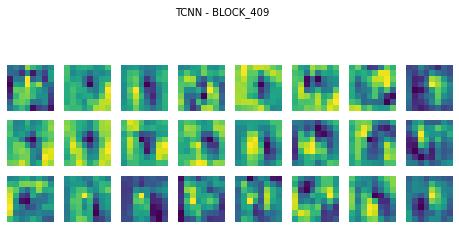

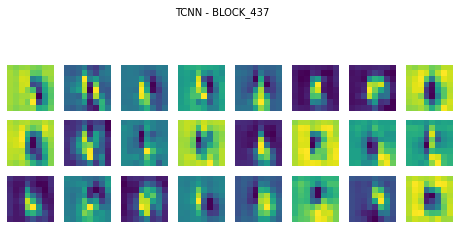

In [63]:
blocks = [174, 203, 335, 409, 437]
for i,fmap in zip(blocks,feature_map):
    fig = pyplot.figure(figsize=(8,8))
    #https://stackoverflow.com/a/12444777
    fig.suptitle("TCNN - BLOCK_{}".format(i) , fontsize=10)
    #for i in range(1,tcnn_features.shape[3]+1):
    for i in range(1,25):
        pyplot.subplot(8,8,i)
        pyplot.axis('off')
        pyplot.imshow(fmap[0,:,:,i-1])  
pyplot.show()

In [58]:
blocks = [69, 98, 230, 304, 332]
outputs = [eff_net.layers[i].output for i in blocks]

eff_net_activation= Model( inputs = eff_net.inputs, outputs = outputs)

In [59]:
eff_net_first_meaningful_layer = Model(inputs = eff_net.inputs, outputs = eff_net.layers[3].output)
eff_net_features = eff_net_first_meaningful_layer.predict(image)
print("finish 1")
feature_map = eff_net_activation.predict(image)
print("finish 2")

finish 1
finish 2


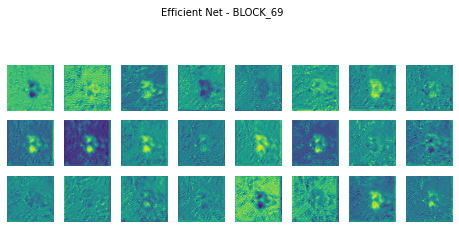

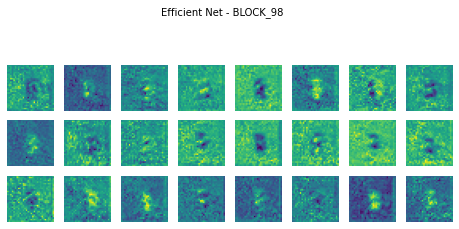

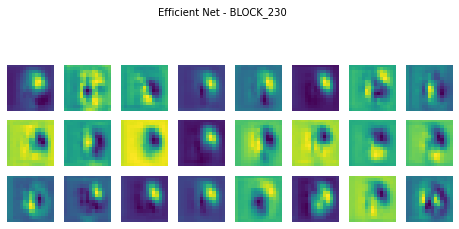

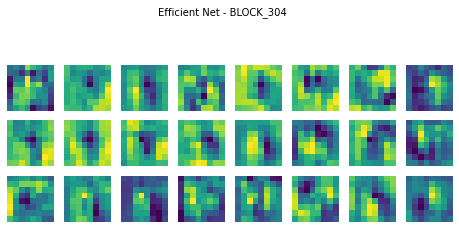

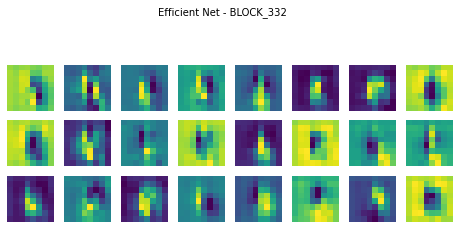

In [61]:
for i,fmap in zip(blocks,feature_map):
    fig = pyplot.figure(figsize=(8,8))
    #https://stackoverflow.com/a/12444777
    fig.suptitle("Efficient Net - BLOCK_{}".format(i) , fontsize=10)
    #for i in range(1,tcnn_features.shape[3]+1):
    for i in range(1,25):
        pyplot.subplot(8,8,i)
        pyplot.axis('off')
        pyplot.imshow(fmap[0,:,:,i-1])  
pyplot.show()